In [27]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
# Connect to the SQL database
conn = psycopg2.connect(
    host="",
    port="",
    database="",
    user="",
    password=""
)

# List of Big 10 opponents
big10_opponents = ["Michigan", "Ohio State", "Penn State", "Michigan State", "Iowa", "Indiana", 
                   "Rutgers", "Maryland", "Purdue", "Illinois", "Minnesota", "Nebraska", 
                   "Northwestern", "Wisconsin", "Ohio State*", "Iowa*", "Michigan*", "Penn State*", "Michigan State*", "Indiana*", 
                   "Rutgers*", "Maryland*", "Purdue*", "Illinois*", "Minnesota*", "Nebraska*", 
                   "Northwestern*", "Wisconsin*"]

# Query for USC
usc_query = """
SELECT date, raw_location, opponent, 
       passing_cmp, passing_att, completion_pct, passing_yds, passing_td, rushing_att, rushing_yds, 
       rushing_avg, rushing_td, total_plays, total_yards, avg_yds, pass_first_downs, rush_first_downs,
       first_down_pens, total_first_downs, total_penalties, total_penalties_yds, total_fum, total_int, 
       total_to, result
FROM USC_Offensive_Stats;
"""
usc_data = pd.read_sql(usc_query, conn)
usc_data['is_big10'] = usc_data['opponent'].apply(lambda x: 1 if x in big10_opponents else 0)
usc_data['team'] = 'USC'

# Ensure that numerical columns are of the correct data type
numeric_columns = ['passing_cmp', 'passing_att', 'passing_yds', 'passing_td', 
                   'rushing_att', 'rushing_yds', 'rushing_td', 'total_yards', 
                   'total_first_downs', 'total_penalties_yds', 'total_fum', 
                   'total_int', 'total_to']

usc_data[numeric_columns] = usc_data[numeric_columns].apply(pd.to_numeric)

print(usc_data.dtypes)

date                    object
raw_location            object
opponent                object
passing_cmp              int64
passing_att              int64
completion_pct         float64
passing_yds              int64
passing_td               int64
rushing_att              int64
rushing_yds              int64
rushing_avg            float64
rushing_td               int64
total_plays              int64
total_yards              int64
avg_yds                float64
pass_first_downs         int64
rush_first_downs         int64
first_down_pens          int64
total_first_downs        int64
total_penalties          int64
total_penalties_yds      int64
total_fum                int64
total_int                int64
total_to                 int64
result                  object
is_big10                 int64
team                    object
dtype: object


In [11]:
# Create a new column 'win' that is 1 for a win and 0 for a loss
usc_data['win'] = usc_data['result'].apply(lambda x: 1 if x.strip()[0] == 'W' else 0)

# Verify the new column
print(usc_data[['result', 'win']].head())

      result  win
0  W (38-27)    1
1  L (24-47)    0
2  L (45-46)    0
3   W (30-7)    1
4  L (28-42)    0


In [12]:
# Calculate win percentage for Big 10 teams
big10_games = usc_data[usc_data['is_big10'] == 1]
non_big10_games = usc_data[usc_data['is_big10'] == 0]

big10_win_pct = big10_games['win'].mean() * 100
non_big10_win_pct = non_big10_games['win'].mean() * 100

print(f"Win Percentage vs. Big 10 Teams: {big10_win_pct:.2f}%")
print(f"Win Percentage vs. Other Teams: {non_big10_win_pct:.2f}%")

Win Percentage vs. Big 10 Teams: 40.00%
Win Percentage vs. Other Teams: 65.41%


In [13]:
# Calculate average offensive stats for Big 10 teams
big10_offensive_stats = big10_games[['passing_cmp', 'passing_att', 'passing_yds', 'passing_td', 
                                     'rushing_att', 'rushing_yds', 'rushing_td', 'total_yards', 
                                     'total_first_downs', 'total_penalties_yds', 'total_fum', 
                                     'total_int', 'total_to']].mean()

# Calculate average offensive stats for non-Big 10 teams
non_big10_offensive_stats = non_big10_games[['passing_cmp', 'passing_att', 'passing_yds', 'passing_td', 
                                             'rushing_att', 'rushing_yds', 'rushing_td', 'total_yards', 
                                             'total_first_downs', 'total_penalties_yds', 'total_fum', 
                                             'total_int', 'total_to']].mean()

print("Offensive Statistics vs. Big 10 Teams:")
print(big10_offensive_stats)
print("\nOffensive Statistics vs. Other Teams:")
print(non_big10_offensive_stats)


Offensive Statistics vs. Big 10 Teams:
passing_cmp             26.8
passing_att             43.8
passing_yds            337.0
passing_td               2.2
rushing_att             30.0
rushing_yds             92.0
rushing_td               1.4
total_yards            429.0
total_first_downs       22.8
total_penalties_yds     59.2
total_fum                1.0
total_int                1.0
total_to                 2.0
dtype: float64

Offensive Statistics vs. Other Teams:
passing_cmp             23.458647
passing_att             35.360902
passing_yds            291.496241
passing_td               2.315789
rushing_att             35.165414
rushing_yds            159.759398
rushing_td               1.766917
total_yards            451.255639
total_first_downs       23.082707
total_penalties_yds     68.834586
total_fum                0.616541
total_int                0.721805
total_to                 1.338346
dtype: float64


In [14]:
usc_def_query = """
SELECT date, location, opponent, 
       opponent_total_yards AS total_yards_allowed, opponent_passing_yds AS passing_yds_allowed, 
       opponent_rushing_yds AS rushing_yds_allowed
FROM USC_Defensive_Stats;
"""
usc_def_data = pd.read_sql(usc_def_query, conn)
usc_def_data['is_big10'] = usc_def_data['opponent'].apply(lambda x: 1 if x in big10_opponents else 0)



# Calculate average defensive stats for Big 10 teams
big10_defensive_stats = usc_def_data[usc_def_data['is_big10'] == 1][['total_yards_allowed', 'passing_yds_allowed', 'rushing_yds_allowed']].mean()

# Calculate average defensive stats for non-Big 10 teams
non_big10_defensive_stats = usc_def_data[usc_def_data['is_big10'] == 0][['total_yards_allowed', 'passing_yds_allowed', 'rushing_yds_allowed']].mean()

print("Defensive Statistics vs. Big 10 Teams:")
print(big10_defensive_stats)
print("\nDefensive Statistics vs. Other Teams:")
print(non_big10_defensive_stats)

Defensive Statistics vs. Big 10 Teams:
total_yards_allowed    397.8
passing_yds_allowed    235.8
rushing_yds_allowed    162.0
dtype: float64

Defensive Statistics vs. Other Teams:
total_yards_allowed    395.488722
passing_yds_allowed    241.857143
rushing_yds_allowed    153.631579
dtype: float64


<Figure size 1000x600 with 0 Axes>

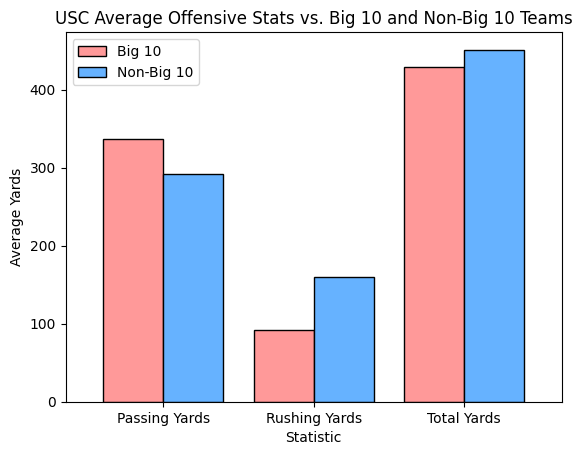

In [24]:
# Ensure the correct calculation of offensive stats
offensive_stats_df = pd.DataFrame({
    'Stat': ['Passing Yards', 'Rushing Yards', 'Total Yards'],
    'Big 10': big10_games[['passing_yds', 'rushing_yds', 'total_yards']].mean().values,
    'Non-Big 10': non_big10_games[['passing_yds', 'rushing_yds', 'total_yards']].mean().values
})

# Plotting the corrected offensive stats
plt.figure(figsize=(10, 6))
offensive_stats_df.plot(kind='bar', x='Stat', color=['#FF9999', '#66B2FF'], edgecolor='black', width=0.8)
plt.title('USC Average Offensive Stats vs. Big 10 and Non-Big 10 Teams')
plt.ylabel('Average Yards')
plt.xlabel('Statistic')
plt.xticks(rotation=0)
plt.legend(['Big 10', 'Non-Big 10'])
plt.show()


<Figure size 1000x600 with 0 Axes>

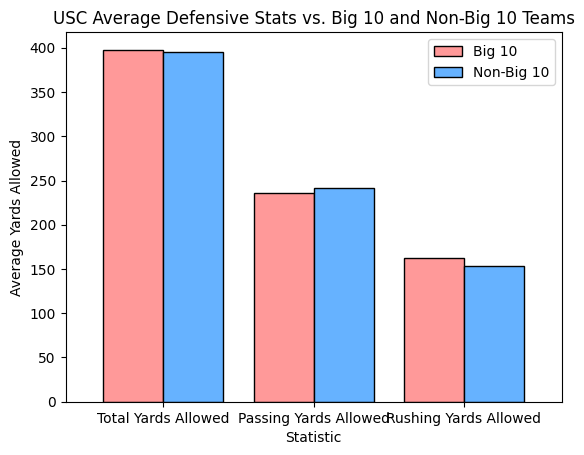

In [23]:
# Calculate average defensive stats for Big 10 and non-Big 10 opponents
defensive_stats_big10 = big10_defensive_stats
defensive_stats_non_big10 = non_big10_defensive_stats

# Create a DataFrame for plotting
defensive_stats_df = pd.DataFrame({
    'Stat': ['Total Yards Allowed', 'Passing Yards Allowed', 'Rushing Yards Allowed'],
    'Big 10': defensive_stats_big10.values,
    'Non-Big 10': defensive_stats_non_big10.values
})

# Plotting the defensive stats
plt.figure(figsize=(10, 6))
defensive_stats_df.plot(kind='bar', x='Stat', color=['#FF9999', '#66B2FF'], edgecolor='black', width=0.8)
plt.title('USC Average Defensive Stats vs. Big 10 and Non-Big 10 Teams')
plt.ylabel('Average Yards Allowed')
plt.xlabel('Statistic')
plt.xticks(rotation=0)
plt.legend(['Big 10', 'Non-Big 10'])
plt.show()


In [17]:
# Defense queries
usc_def_query = """
SELECT date, location, opponent, 
       opponent_passing_cmp, opponent_passing_att, opponent_completion_pct, opponent_passing_yds, 
       opponent_passing_td, opponent_rushing_att, opponent_rushing_yds, opponent_rushing_avg, 
       opponent_rushing_td, opponent_total_plays, opponent_total_yards, opponent_avg_yds,
       opponent_pass_first_downs, opponent_rush_first_downs, opponent_first_down_pens, 
       opponent_total_first_downs, opponent_total_penalties, opponent_total_penalties_yds, 
       opponent_total_fum, opponent_total_int, opponent_total_to, temp_f, precipitation_in, 
       windspeed_mph, altitude_m, distance_from
FROM USC_Defensive_Stats;
"""
usc_def_data = pd.read_sql(usc_def_query, conn)
usc_def_data['is_big10'] = usc_def_data['opponent'].apply(lambda x: 1 if x in big10_opponents else 0)

In [18]:
# Group the data by Big 10 and non-Big 10 games for offensive stats
offensive_grouped = usc_data.groupby('is_big10').agg({
    'passing_yds': 'mean',
    'rushing_yds': 'mean',
    'total_yards': 'mean',
    'completion_pct': 'mean',
    'passing_td': 'mean',
    'rushing_att': 'mean',
    'rushing_td': 'mean',
    'total_first_downs': 'mean',
    'total_to': 'mean'
}).reset_index()

# Rename the columns for clarity
offensive_grouped['Category'] = offensive_grouped['is_big10'].map({1: 'Big 10', 0: 'Non-Big 10'})

# Repeat for defensive stats
defensive_grouped = usc_def_data.groupby('is_big10').agg({
    'opponent_passing_yds': 'mean',
    'opponent_rushing_yds': 'mean',
    'opponent_total_yards': 'mean',
    'opponent_completion_pct': 'mean',
    'opponent_passing_td': 'mean',
    'opponent_rushing_att': 'mean',
    'opponent_rushing_td': 'mean',
    'opponent_total_first_downs': 'mean',
    'opponent_total_to': 'mean'
}).reset_index()

# Rename the columns for clarity
defensive_grouped['Category'] = defensive_grouped['is_big10'].map({1: 'Big 10', 0: 'Non-Big 10'})


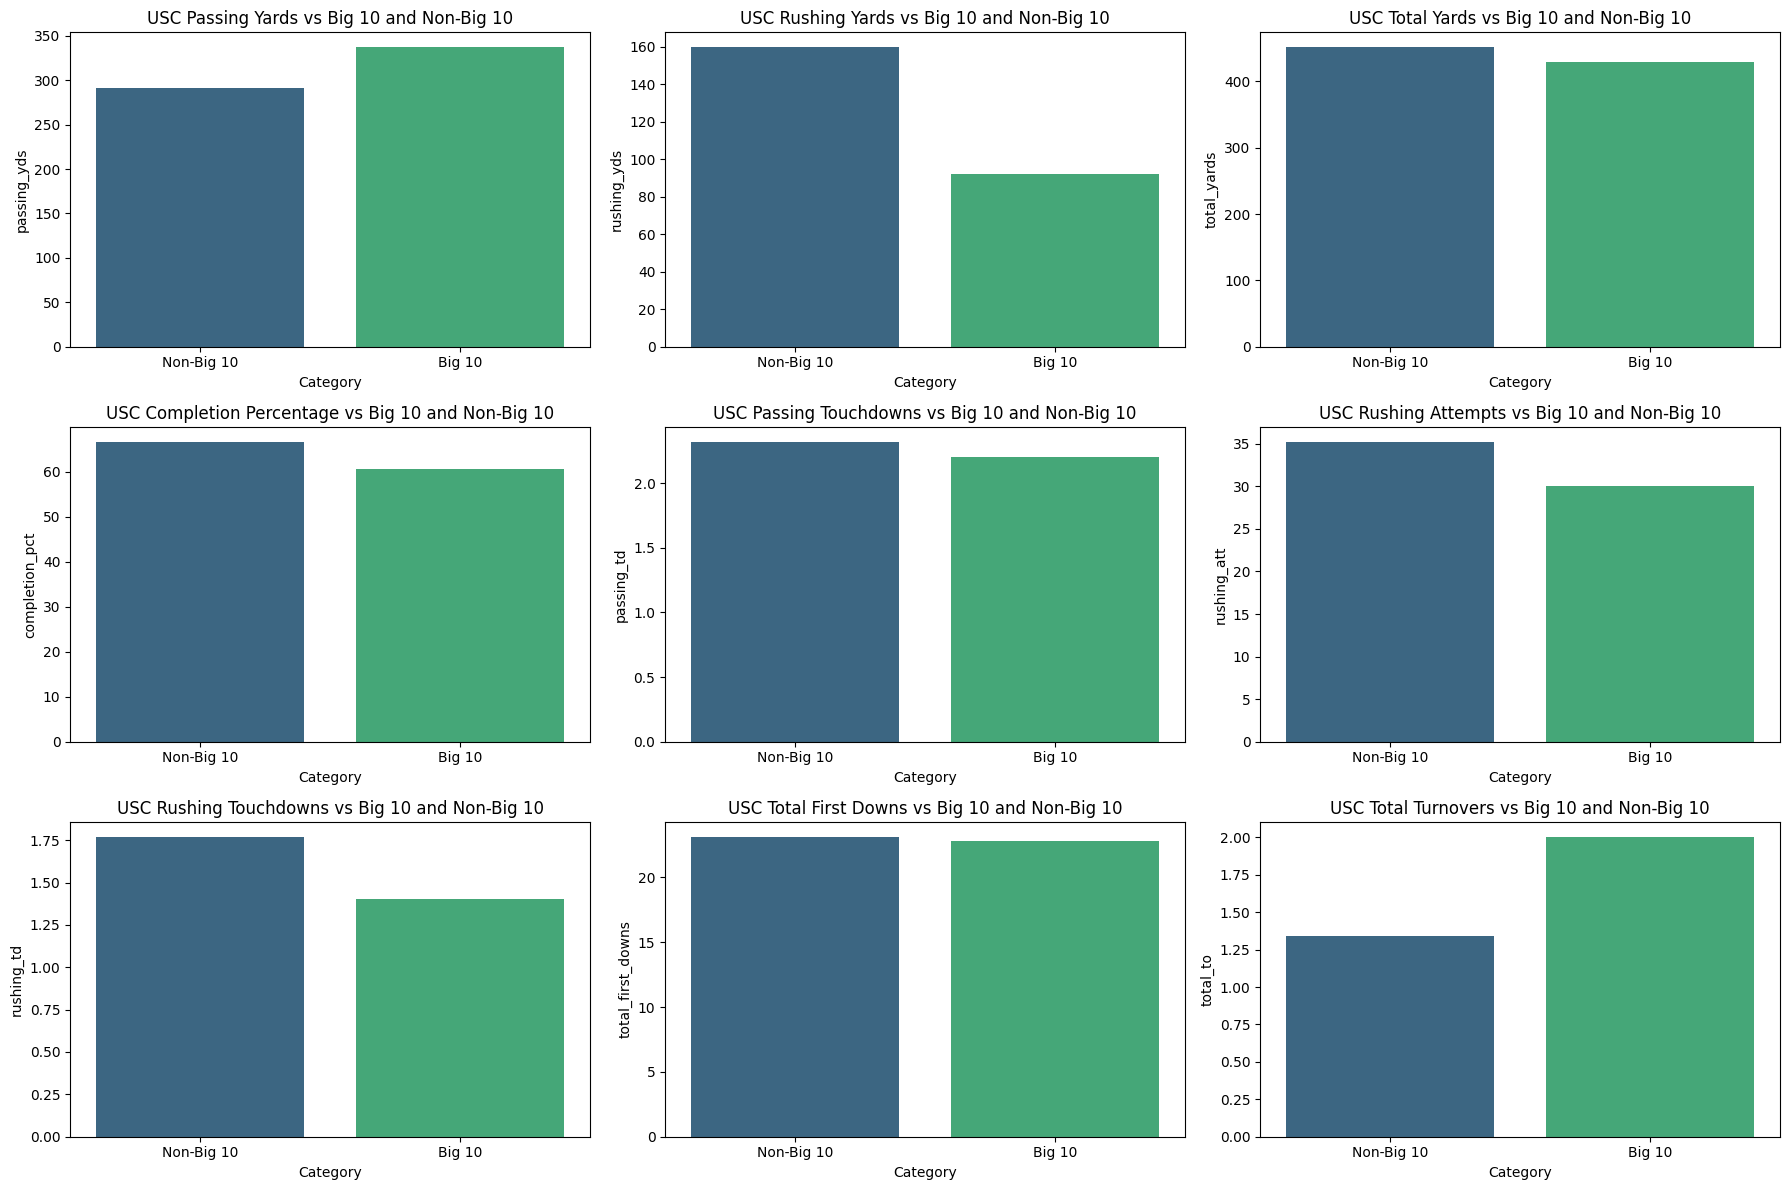

In [25]:
# Set up the plot
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Passing Yards
sns.barplot(x='Category', y='passing_yds', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[0, 0], dodge=False)
axs[0, 0].set_title('USC Passing Yards vs Big 10 and Non-Big 10')

# Rushing Yards
sns.barplot(x='Category', y='rushing_yds', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[0, 1], dodge=False)
axs[0, 1].set_title('USC Rushing Yards vs Big 10 and Non-Big 10')

# Total Yards
sns.barplot(x='Category', y='total_yards', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[0, 2], dodge=False)
axs[0, 2].set_title('USC Total Yards vs Big 10 and Non-Big 10')

# Completion Percentage
sns.barplot(x='Category', y='completion_pct', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[1, 0], dodge=False)
axs[1, 0].set_title('USC Completion Percentage vs Big 10 and Non-Big 10')

# Passing Touchdowns
sns.barplot(x='Category', y='passing_td', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[1, 1], dodge=False)
axs[1, 1].set_title('USC Passing Touchdowns vs Big 10 and Non-Big 10')

# Rushing Attempts
sns.barplot(x='Category', y='rushing_att', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[1, 2], dodge=False)
axs[1, 2].set_title('USC Rushing Attempts vs Big 10 and Non-Big 10')

# Rushing Touchdowns
sns.barplot(x='Category', y='rushing_td', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[2, 0], dodge=False)
axs[2, 0].set_title('USC Rushing Touchdowns vs Big 10 and Non-Big 10')

# Total First Downs
sns.barplot(x='Category', y='total_first_downs', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[2, 1], dodge=False)
axs[2, 1].set_title('USC Total First Downs vs Big 10 and Non-Big 10')

# Total Turnovers
sns.barplot(x='Category', y='total_to', data=offensive_grouped, hue='Category', palette='viridis', ax=axs[2, 2], dodge=False)
axs[2, 2].set_title('USC Total Turnovers vs Big 10 and Non-Big 10')

# Adjust layout
plt.tight_layout()
plt.show()


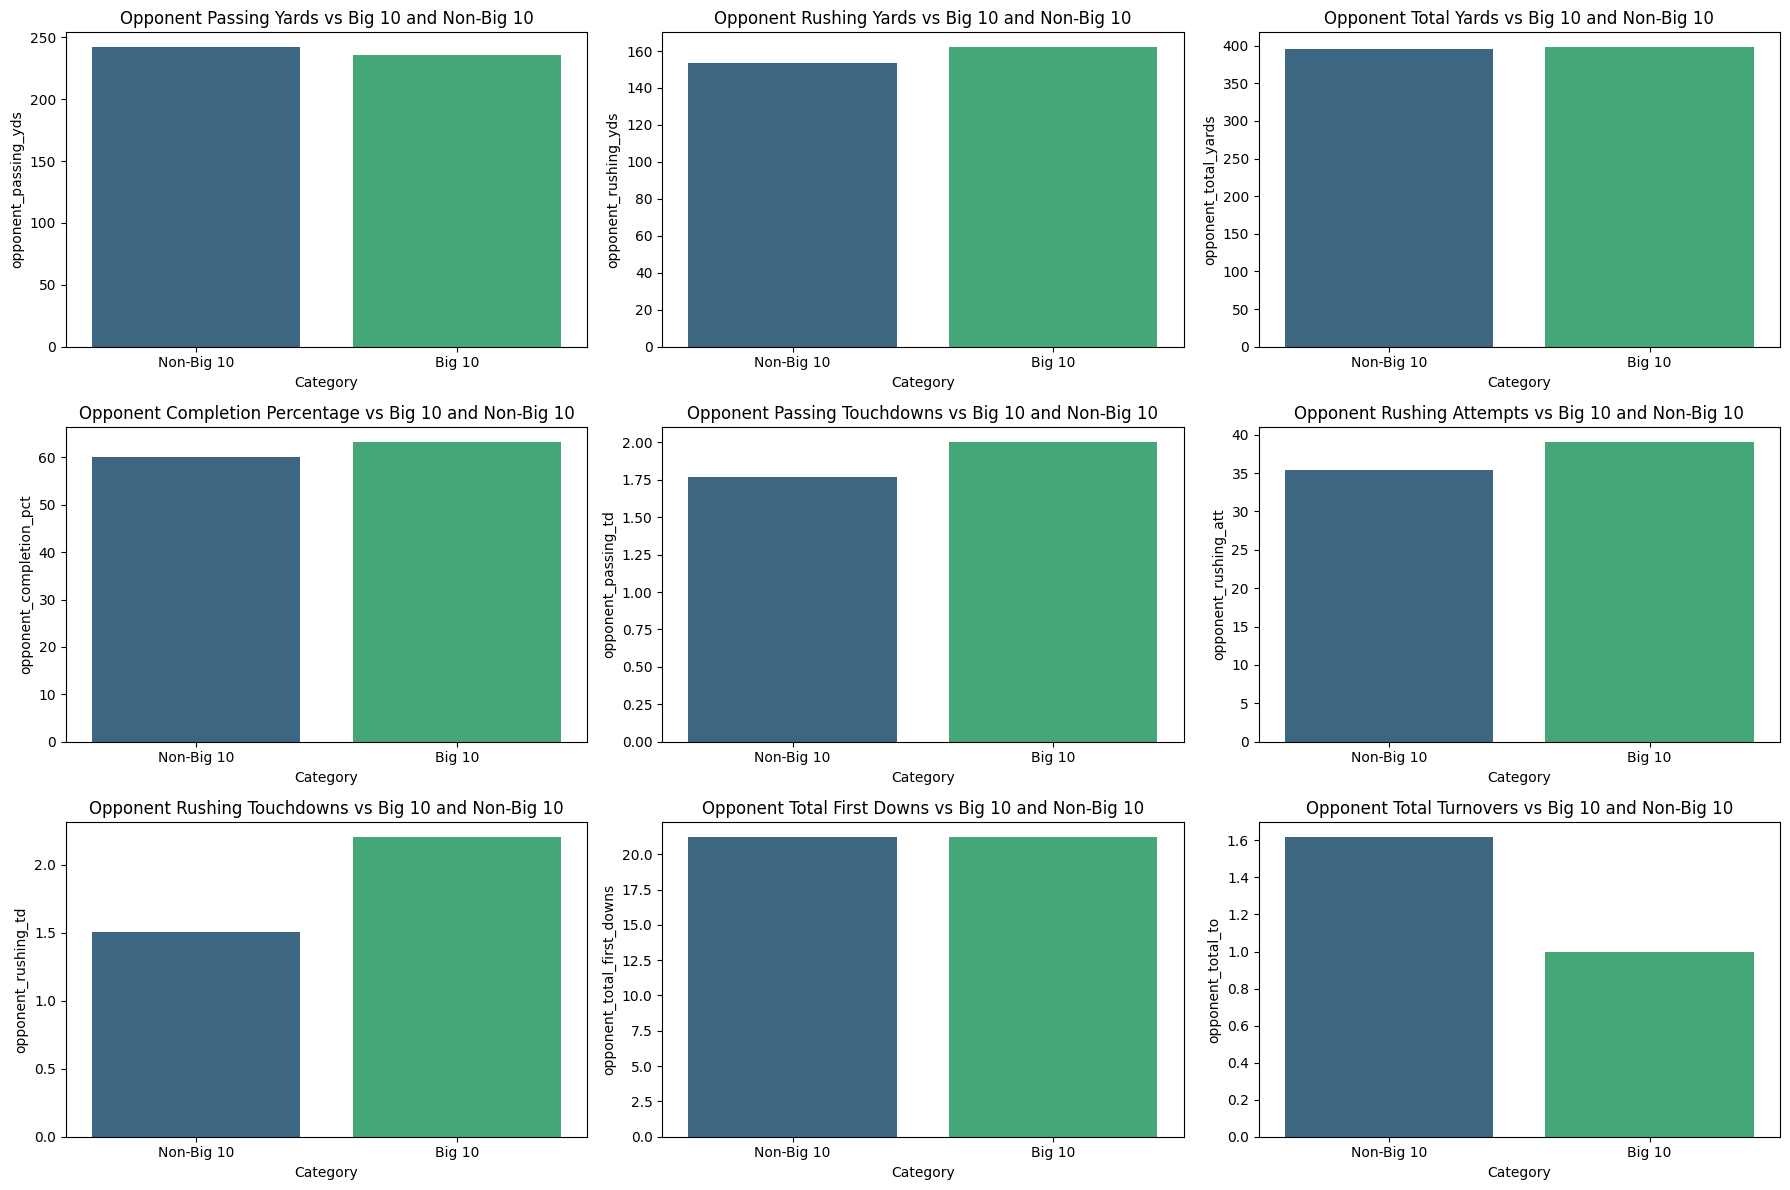

In [20]:
# Set up the plot
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Opponent Passing Yards
sns.barplot(x='Category', y='opponent_passing_yds', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[0, 0], dodge=False)
axs[0, 0].set_title('USC Opponent Passing Yards vs Big 10 and Non-Big 10')

# Opponent Rushing Yards
sns.barplot(x='Category', y='opponent_rushing_yds', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[0, 1], dodge=False)
axs[0, 1].set_title('USC Opponent Rushing Yards vs Big 10 and Non-Big 10')

# Opponent Total Yards
sns.barplot(x='Category', y='opponent_total_yards', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[0, 2], dodge=False)
axs[0, 2].set_title('USC Opponent Total Yards vs Big 10 and Non-Big 10')

# Opponent Completion Percentage
sns.barplot(x='Category', y='opponent_completion_pct', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[1, 0], dodge=False)
axs[1, 0].set_title('USC Opponent Completion Percentage vs Big 10 and Non-Big 10')

# Opponent Passing Touchdowns
sns.barplot(x='Category', y='opponent_passing_td', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[1, 1], dodge=False)
axs[1, 1].set_title('USC Opponent Passing Touchdowns vs Big 10 and Non-Big 10')

# Opponent Rushing Attempts
sns.barplot(x='Category', y='opponent_rushing_att', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[1, 2], dodge=False)
axs[1, 2].set_title('USC Opponent Rushing Attempts vs Big 10 and Non-Big 10')

# Opponent Rushing Touchdowns
sns.barplot(x='Category', y='opponent_rushing_td', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[2, 0], dodge=False)
axs[2, 0].set_title('USC Opponent Rushing Touchdowns vs Big 10 and Non-Big 10')

# Opponent Total First Downs
sns.barplot(x='Category', y='opponent_total_first_downs', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[2, 1], dodge=False)
axs[2, 1].set_title('USC Opponent Total First Downs vs Big 10 and Non-Big 10')

# Opponent Total Turnovers
sns.barplot(x='Category', y='opponent_total_to', data=defensive_grouped, hue='Category', palette='viridis', ax=axs[2, 2], dodge=False)
axs[2, 2].set_title('USC Opponent Total Turnovers vs Big 10 and Non-Big 10')

# Adjust layout
plt.tight_layout()
plt.show()


In [21]:
# Calculate rush-pass percentage for Big 10 teams
big10_games['rush_pct'] = big10_games['rushing_att'] / (big10_games['rushing_att'] + big10_games['passing_att']) * 100
big10_games['pass_pct'] = big10_games['passing_att'] / (big10_games['rushing_att'] + big10_games['passing_att']) * 100

# Calculate rush-pass percentage for non-Big 10 teams
non_big10_games['rush_pct'] = non_big10_games['rushing_att'] / (non_big10_games['rushing_att'] + non_big10_games['passing_att']) * 100
non_big10_games['pass_pct'] = non_big10_games['passing_att'] / (non_big10_games['rushing_att'] + non_big10_games['passing_att']) * 100

# Calculate average rush-pass percentage for both groups
rush_pass_pct = pd.DataFrame({
    'Category': ['Big 10', 'Big 10', 'Non-Big 10', 'Non-Big 10'],
    'Type': ['Rush %', 'Pass %', 'Rush %', 'Pass %'],
    'Percentage': [
        big10_games['rush_pct'].mean(),
        big10_games['pass_pct'].mean(),
        non_big10_games['rush_pct'].mean(),
        non_big10_games['pass_pct'].mean()
    ]
})

print(rush_pass_pct)

     Category    Type  Percentage
0      Big 10  Rush %   40.566103
1      Big 10  Pass %   59.433897
2  Non-Big 10  Rush %   49.794838
3  Non-Big 10  Pass %   50.205162


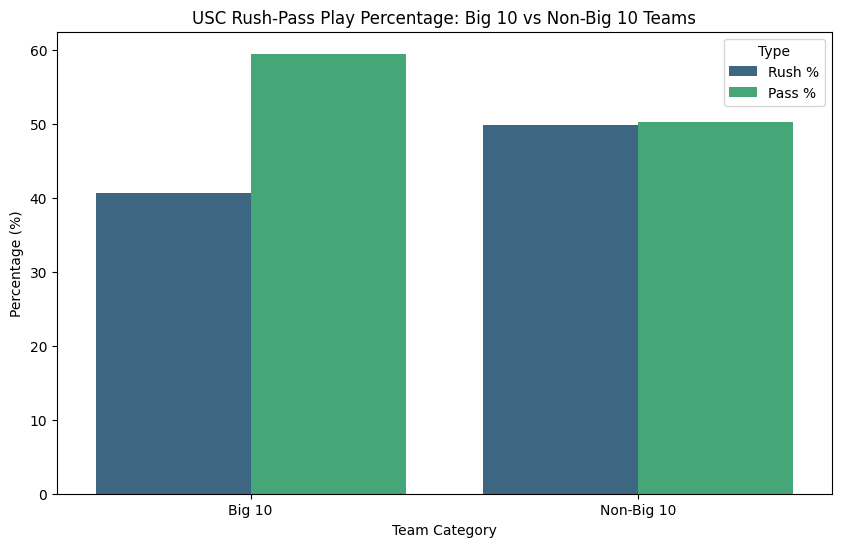

In [26]:
# Plotting the rush-pass percentage
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Percentage', hue='Type', data=rush_pass_pct, palette='viridis')

# Set plot title and labels
plt.title('USC Rush-Pass Play Percentage: Big 10 vs Non-Big 10 Teams')
plt.ylabel('Percentage (%)')
plt.xlabel('Team Category')

# Display the plot
plt.show()
